In [ ]:
import os
import sys
sys.path.append('/home/longshen/work/AccGen/AccGen')

from models.ldm_inference import PhraseLDM
from sonata_utils import create_dir_if_not_exist
from remi_z import MultiTrack

/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Run this to obtain MIDI from a model

model_fp = '/data1/longshen/Results/AccGenResults/diffusion_prior/phr_latent/full_song/baseline_lencond/tb_logs/version_2/checkpoints/step_step=160000.ckpt'
model_fp = '/data1/longshen/Results/AccGenResults/diffusion_prior/phr_latent/full_song/ft_from_section_permute/baseline/tb_logs/version_0/checkpoints/step_step=100000.ckpt'

model = PhraseLDM(length_control=True, ckpt_fp=model_fp)
# model = PhraseLDM(ckpt_fp=model_fp)
model = model.cuda()

n_song = 10
n_bar = 64

# out, latent = model.generate(n_sample=1, bar_sep=' ')
out, latent = model.generate(n_sample=n_song, bar_sep=' ', n_bars=n_bar)
# out = out[0]
# latent = latent[0]

# Calculate memorization rate
# mt = MultiTrack.from_remiz_str(out, remove_repeated_eob=True)
from evaluation.metrics import Metric
metric = Metric()

mem_rates = []
for i in range(n_song):
    mt = MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True)
    mem_rate = metric.memorization_rate_mt_batch([mt])
    mem_rates.append(mem_rate)

# Compute new sample rate
new_sample_rate, _, top2_ratios = metric.new_sample_rate_batch([MultiTrack.from_remiz_str(s, remove_repeated_eob=True) for s in out])
print('New sample rate of generated samples:', new_sample_rate)
memorized_samples = [True if top2_ratios[i] < 0.3333 else False for i in range(n_song)]

# Save MIDI
step = os.path.basename(model_fp).split('=')[-1].split('.')[0]
kstep = int(step) // 1000
save_dir = f'/data1/longshen/Results/AccGenResults/test_outputs/ldm/PhrLDM/lencond/to_evaluate/step{kstep}k'
create_dir_if_not_exist(save_dir)
for i in range(n_song):
    mt = MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True)
    mem_rate = mem_rates[i]
    save_fn = f'{n_bar}bar_{i}_mem{mem_rate:.2f}_memorized{memorized_samples[i]}.mid'
    save_fp = os.path.join(save_dir, save_fn)
    create_dir_if_not_exist(os.path.dirname(save_fp))
    mt.to_midi(save_fp, tempo=90, verbose=False)




  0%|          | 0/1000 [00:00<?, ?it/s]/home/longshen/work/AccGen/AccGen/models/diffusion_prior_onebar.py:202: FutureWarning: Accessing config attribute `attention_head_dim` directly via 'UnconditionalDiT' object attribute is deprecated. Please access 'attention_head_dim' over 'UnconditionalDiT's config object instead, e.g. 'unet.config.attention_head_dim'.
  rotary_embed_dim = self.attention_head_dim // 2
/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:35: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Computing top-two ratios: 100%|██████████| 10/10 [00:07<00:00,  1.3

New sample rate of generated samples: 0.4


In [ ]:
from evaluation.metrics import visualize_ssm_for_song_bar
from the_utils.latent_utils import truncate_by_self_similarity

z_trunc, n_bars = truncate_by_self_similarity(latent, pad_threshold=0.6)

visualize_ssm_for_song_bar(z_trunc, show=True)


NameError: name 'latent' is not defined

BRS diag for song 283: 0.6923


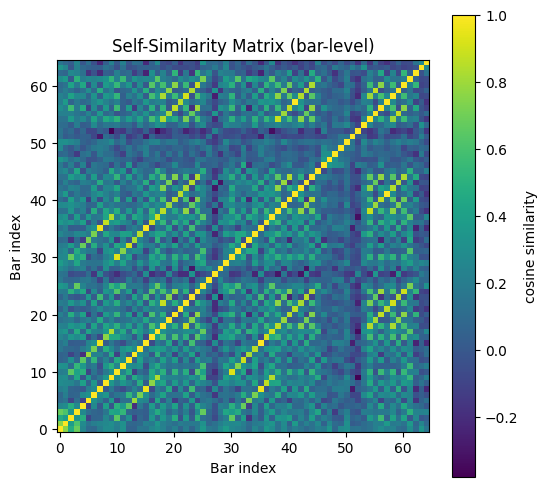

In [ ]:
# Check SSM of a song in the dataset
import torch
eval_latent_fp = '/data1/longshen/Datasets/Piano/POP909/latents/song_level_phr_seq_with_annot/song_level_latents_with_phrase_annot.pt'
eval_data = torch.load(eval_latent_fp, map_location='cpu') # list of latents
check_id = '283'
latent = eval_data[check_id]['latent']  # (n_bars, latent_dim)



from evaluation.metrics import compute_fid, compute_diversity, compute_ngram_fid, bright_ratio, compute_bar_ssm_from_phrase_latents, bar_recurrence_score_diag
srs = bar_recurrence_score_diag(latent, threshold=0.5, min_run_length=4)
print(f"BRS diag for song {check_id}: {srs:.4f}")

visualize_ssm_for_song_bar(latent, show=True)

In [1]:
model_fp = '/data1/longshen/Results/AccGenResults/diffusion_prior/phr_latent/full_song/section_subset/tb_logs/version_9/checkpoints/last.ckpt'
# model_fp = '/data1/longshen/Results/AccGenResults/diffusion_prior/phr_latent/full_song/ft_from_bar_permute/lencond_baseline/tb_logs/version_6/checkpoints/last.ckpt'

model = PhraseLDM(ckpt_fp=model_fp)
# model = PhraseLDM(length_control=True, ckpt_fp=model_fp)
model = model.cuda()
latent = model.generate(n_sample=1, bar_sep=' ', decode=False, n_bars=64)[0]

from evaluation.metrics import visualize_ssm_for_song_bar
from the_utils.latent_utils import truncate_by_self_similarity

z_trunc, n_bars = truncate_by_self_similarity(latent, pad_threshold=0.99)

visualize_ssm_for_song_bar(z_trunc, show=True)


NameError: name 'PhraseLDM' is not defined

In [ ]:
from evaluation.metrics import bar_recurrence_score_diag
brs = bar_recurrence_score_diag(z_trunc, threshold=0.5, min_run_length=2)
print(f'BRS: {brs}')

BRS: 0.08661417322834646


In [2]:
''' Latest inference code '''

import os
import sys
sys.path.append('/home/longshen/work/AccGen/AccGen')

from models.ldm_inference import PhraseLDM
from sonata_utils import create_dir_if_not_exist
from remi_z import MultiTrack
from the_utils.midi_utils import save_midi

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Run this to obtain MIDI from a model

model_fp = '/data1/longshen/Results/AccGenResults/diffusion_prior/phr_latent/full_song/64dim_latent/unconditional/tb_logs/version_2/checkpoints/last.ckpt'

model_name = 'uncond_test'
pt = 'from_scratch'
n_song = 5
n_bar = 64
lencond = False

model = PhraseLDM(ckpt_fp=model_fp, length_control=lencond)
model = model.cuda()
out, latent = model.generate(n_sample=n_song, bar_sep=' ', n_bars=n_bar)

# Calculate memorization rate
from evaluation.metrics import Metric
metric = Metric()

sample_lens = []
mem_rates = []
mts = [MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True) for i in range(n_song)]
mem_rates = metric.memorization_rate_mt_batch(mts, return_list=True)
for i in range(n_song):
    mt = MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True)
    sample_lens.append(len(mt))

# Compute new sample rate
new_sample_rate, _, top2_ratios = metric.new_sample_rate_batch([MultiTrack.from_remiz_str(s, remove_repeated_eob=True) for s in out])
print('New sample rate of generated samples:', new_sample_rate)
memorized_samples = [True if top2_ratios[i] < 0.3333 else False for i in range(n_song)]

# Compute section recurrence score
srs = metric.compute_srs(latent, sample_lens)
print('Section Recurrence Scores of generated samples:', srs)

# Compute FID
fid = metric.compute_fid(out_tensor=latent, out_n_bars=sample_lens)
print('FID of generated samples:', fid)

# Save MIDI
if 'last' in os.path.basename(model_fp):
    step_str = 'last'
else:
    step = os.path.basename(model_fp).split('=')[-1].split('.')[0]
    kstep = int(step) // 1000
    step_str = f'{kstep}k'
save_dir = f'/data1/longshen/Results/AccGenResults/test_outputs/ldm/PhrLDM/{model_name}/{pt}/step_{step_str}'
create_dir_if_not_exist(save_dir)
for i in range(n_song):
    mt = MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True)
    mem_rate = mem_rates[i]
    save_fn = f'{n_bar}bar_{i}_mem{mem_rate:.2f}_memorized{memorized_samples[i]}.mid'
    save_fp = os.path.join(save_dir, save_fn)
    create_dir_if_not_exist(os.path.dirname(save_fp))
    save_midi(mt, save_fp)




VAE scale factor: 0.7590118646621704


  0%|          | 0/1000 [00:00<?, ?it/s]/home/longshen/work/AccGen/AccGen/models/diffusion_prior_onebar.py:369: FutureWarning: Accessing config attribute `attention_head_dim` directly via 'UnconditionalDiT' object attribute is deprecated. Please access 'attention_head_dim' over 'UnconditionalDiT's config object instead, e.g. 'unet.config.attention_head_dim'.
  rotary_embed_dim = self.attention_head_dim // 2
/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:35: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Computing top-two ratios: 100%|██████████| 5/5 [00:04<00:00,  1.23i

New sample rate of generated samples: 1.0
Section Recurrence Scores of generated samples: 0.07961562052749949
FID of generated samples: 6.201074004173279


In [1]:
''' Latest inference code for section conditioned model '''

import os
import sys
sys.path.append('/home/longshen/work/AccGen/AccGen')

from models.ldm_inference import PhraseLDM
from sonata_utils import create_dir_if_not_exist
from remi_z import MultiTrack
from the_utils.midi_utils import save_midi

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Run this to obtain MIDI from a model

model_fp = '/data1/longshen/Results/AccGenResults/diffusion_prior/phr_latent/full_song/64dim_latent/seccond/tb_logs/version_0/checkpoints/step_step=200000.ckpt'
save_root = '/data1/longshen/Results/AccGenResults/test_outputs/ldm/PhrLDM/seccond'
model_name = 'seccond_baseline'
pt = 'from_scratch'
n_song = 5
n_bar = 64
lencond = True
sec_control = True
sec_cond = ' '.join([
    "i-8",
    "A-8",
    "A-8",
    "B-4",
    "B-4",
    "x-4",
    "A-8",
    "B-4",
    "B-4",
    "B-4",
    "B-4",
    "X-4"
])

model = PhraseLDM(ckpt_fp=model_fp, length_control=lencond, sec_control=sec_control)
model.eval()
model = model.cuda()
out, latent = model.generate(n_sample=n_song, bar_sep=' ', n_bars=n_bar, sec_cond=sec_cond)

# Calculate memorization rate
from evaluation.metrics import Metric
metric = Metric()

sample_lens = []
mem_rates = []
mts = [MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True) for i in range(n_song)]
mem_rates = metric.memorization_rate_mt_batch(mts, return_list=True)
for i in range(n_song):
    mt = MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True)
    sample_lens.append(len(mt))

# Compute new sample rate
new_sample_rate, _, top2_ratios = metric.new_sample_rate_batch([MultiTrack.from_remiz_str(s, remove_repeated_eob=True) for s in out])
print('New sample rate of generated samples:', new_sample_rate)
memorized_samples = [True if top2_ratios[i] < 0.3333 else False for i in range(n_song)]

# Compute section recurrence score
srs = metric.compute_srs(latent, sample_lens)
print('Section Recurrence Scores of generated samples:', srs)

# Compute FID
fid = metric.compute_fid(out_tensor=latent, out_n_bars=sample_lens)
print('FID of generated samples:', fid)

# Save MIDI
if 'last' in os.path.basename(model_fp):
    step_str = 'last'
else:
    step = os.path.basename(model_fp).split('=')[-1].split('.')[0]
    kstep = int(step) // 1000
    step_str = f'{kstep}k'
save_dir = f'{save_root}/{model_name}/{pt}/step_{step_str}'
create_dir_if_not_exist(save_dir)
for i in range(n_song):
    mt = MultiTrack.from_remiz_str(out[i], remove_repeated_eob=True)
    mem_rate = mem_rates[i]
    save_fn = f'{n_bar}bar_{i}_mem{mem_rate:.2f}_memorized{memorized_samples[i]}.mid'
    save_fp = os.path.join(save_dir, save_fn)
    create_dir_if_not_exist(os.path.dirname(save_fp))
    save_midi(mt, save_fp)




/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VAE scale factor: 0.7590118646621704
Length Buckets: tensor([6, 6, 6, 6, 6], device='cuda:0')


  0%|          | 0/1000 [00:00<?, ?it/s]/home/longshen/work/AccGen/AccGen/models/diffusion_prior_onebar.py:369: FutureWarning: Accessing config attribute `attention_head_dim` directly via 'UnconditionalDiT' object attribute is deprecated. Please access 'attention_head_dim' over 'UnconditionalDiT's config object instead, e.g. 'unet.config.attention_head_dim'.
  rotary_embed_dim = self.attention_head_dim // 2
/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:35: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Computing top-two ratios: 100%|██████████| 5/5 [00:03<00:00,  1.35i

New sample rate of generated samples: 1.0
Section Recurrence Scores of generated samples: 0.024039829302987197
FID of generated samples: 16.260034501552582
